# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 4000
lr = 1e-7
batch_size = 10
num_workers = 1

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.1] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [10]:
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
    
    # create model
    model = resnet18(drop_prob=drop_prob)
    model = model.to(device)
    
    # Handle loss function and optimizer
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    # used to track the loss and accuracy over each epoch
    stats = np.zeros(shape=(num_epoch, 2, 2))

    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1

    # handle training and testing dataloaders
    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.3f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.1
Epoch:    1 Tr loss: 2.888 Ts loss: 2.692 Tr Accuracy: 12.14% Ts Accuracy: 13.20% Time: 2.29s p=0.10 save!
Epoch:    2 Tr loss: 2.840 Ts loss: 2.660 Tr Accuracy: 14.55% Ts Accuracy: 16.13% Time: 3.94s p=0.10 save!
Epoch:    3 Tr loss: 2.739 Ts loss: 2.663 Tr Accuracy: 13.97% Ts Accuracy: 13.78% Time: 5.62s p=0.10 
Epoch:    4 Tr loss: 2.701 Ts loss: 2.604 Tr Accuracy: 16.84% Ts Accuracy: 15.54% Time: 7.52s p=0.10 
Epoch:    5 Tr loss: 2.699 Ts loss: 2.576 Tr Accuracy: 15.01% Ts Accuracy: 17.01% Time: 9.16s p=0.10 save!
Epoch:    6 Tr loss: 2.623 Ts loss: 2.571 Tr Accuracy: 16.15% Ts Accuracy: 15.25% Time: 10.79s p=0.10 
Epoch:    7 Tr loss: 2.567 Ts loss: 2.544 Tr Accuracy: 18.79% Ts Accuracy: 17.01% Time: 12.43s p=0.10 
Epoch:    8 Tr loss: 2.563 Ts loss: 2.519 Tr Accuracy: 16.61% Ts Accuracy: 15.54% Time: 14.07s p=0.10 
Epoch:    9 Tr loss: 2.535 Ts loss: 2.507 Tr Accuracy: 16.72% Ts Accuracy: 16.72% Time: 15.74s p=0.10 
Epoch:   10 Tr loss: 2.519 Ts loss: 2.490 Tr Acc

Epoch:   79 Tr loss: 1.706 Ts loss: 1.966 Tr Accuracy: 38.83% Ts Accuracy: 41.64% Time: 130.42s p=0.10 
Epoch:   80 Tr loss: 1.720 Ts loss: 1.926 Tr Accuracy: 39.29% Ts Accuracy: 42.82% Time: 132.10s p=0.10 
Epoch:   81 Tr loss: 1.742 Ts loss: 1.860 Tr Accuracy: 36.88% Ts Accuracy: 45.45% Time: 133.68s p=0.10 save!
Epoch:   82 Tr loss: 1.721 Ts loss: 1.910 Tr Accuracy: 36.31% Ts Accuracy: 43.40% Time: 135.24s p=0.10 
Epoch:   83 Tr loss: 1.699 Ts loss: 1.906 Tr Accuracy: 41.92% Ts Accuracy: 41.06% Time: 136.79s p=0.10 
Epoch:   84 Tr loss: 1.704 Ts loss: 1.900 Tr Accuracy: 38.03% Ts Accuracy: 43.40% Time: 138.45s p=0.10 
Epoch:   85 Tr loss: 1.702 Ts loss: 1.903 Tr Accuracy: 39.75% Ts Accuracy: 42.23% Time: 140.08s p=0.10 
Epoch:   86 Tr loss: 1.689 Ts loss: 1.878 Tr Accuracy: 39.98% Ts Accuracy: 43.40% Time: 141.72s p=0.10 
Epoch:   87 Tr loss: 1.685 Ts loss: 1.873 Tr Accuracy: 39.06% Ts Accuracy: 43.70% Time: 143.36s p=0.10 
Epoch:   88 Tr loss: 1.669 Ts loss: 1.874 Tr Accuracy: 40.6

Epoch:  157 Tr loss: 1.367 Ts loss: 1.683 Tr Accuracy: 53.38% Ts Accuracy: 52.79% Time: 256.51s p=0.10 
Epoch:  158 Tr loss: 1.372 Ts loss: 1.632 Tr Accuracy: 51.66% Ts Accuracy: 55.72% Time: 258.16s p=0.10 
Epoch:  159 Tr loss: 1.391 Ts loss: 1.578 Tr Accuracy: 50.74% Ts Accuracy: 56.60% Time: 259.88s p=0.10 
Epoch:  160 Tr loss: 1.364 Ts loss: 1.569 Tr Accuracy: 52.46% Ts Accuracy: 59.53% Time: 261.45s p=0.10 save!
Epoch:  161 Tr loss: 1.340 Ts loss: 1.545 Tr Accuracy: 55.90% Ts Accuracy: 57.77% Time: 263.07s p=0.10 
Epoch:  162 Tr loss: 1.336 Ts loss: 1.569 Tr Accuracy: 56.13% Ts Accuracy: 58.06% Time: 264.65s p=0.10 
Epoch:  163 Tr loss: 1.351 Ts loss: 1.585 Tr Accuracy: 53.72% Ts Accuracy: 56.60% Time: 266.29s p=0.10 
Epoch:  164 Tr loss: 1.329 Ts loss: 1.625 Tr Accuracy: 54.41% Ts Accuracy: 56.30% Time: 267.86s p=0.10 
Epoch:  165 Tr loss: 1.345 Ts loss: 1.518 Tr Accuracy: 54.41% Ts Accuracy: 58.36% Time: 269.47s p=0.10 
Epoch:  166 Tr loss: 1.344 Ts loss: 1.557 Tr Accuracy: 54.5

Epoch:  236 Tr loss: 1.154 Ts loss: 1.462 Tr Accuracy: 62.20% Ts Accuracy: 58.36% Time: 384.98s p=0.10 
Epoch:  237 Tr loss: 1.147 Ts loss: 1.401 Tr Accuracy: 61.74% Ts Accuracy: 61.29% Time: 386.56s p=0.10 
Epoch:  238 Tr loss: 1.133 Ts loss: 1.367 Tr Accuracy: 63.12% Ts Accuracy: 62.76% Time: 388.14s p=0.10 
Epoch:  239 Tr loss: 1.173 Ts loss: 1.302 Tr Accuracy: 60.94% Ts Accuracy: 64.52% Time: 389.75s p=0.10 
Epoch:  240 Tr loss: 1.138 Ts loss: 1.342 Tr Accuracy: 63.12% Ts Accuracy: 63.64% Time: 391.33s p=0.10 
Epoch:  241 Tr loss: 1.148 Ts loss: 1.408 Tr Accuracy: 62.08% Ts Accuracy: 61.00% Time: 392.91s p=0.10 
Epoch:  242 Tr loss: 1.150 Ts loss: 1.411 Tr Accuracy: 62.89% Ts Accuracy: 60.70% Time: 394.48s p=0.10 
Epoch:  243 Tr loss: 1.132 Ts loss: 1.340 Tr Accuracy: 62.89% Ts Accuracy: 63.93% Time: 396.04s p=0.10 
Epoch:  244 Tr loss: 1.147 Ts loss: 1.321 Tr Accuracy: 60.25% Ts Accuracy: 63.05% Time: 397.62s p=0.10 
Epoch:  245 Tr loss: 1.154 Ts loss: 1.284 Tr Accuracy: 63.12% Ts

Epoch:  315 Tr loss: 0.984 Ts loss: 1.184 Tr Accuracy: 69.30% Ts Accuracy: 68.04% Time: 512.40s p=0.10 
Epoch:  316 Tr loss: 0.975 Ts loss: 1.238 Tr Accuracy: 69.07% Ts Accuracy: 65.10% Time: 514.10s p=0.10 
Epoch:  317 Tr loss: 0.972 Ts loss: 1.213 Tr Accuracy: 68.96% Ts Accuracy: 65.10% Time: 515.71s p=0.10 
Epoch:  318 Tr loss: 0.976 Ts loss: 1.218 Tr Accuracy: 69.42% Ts Accuracy: 66.86% Time: 517.33s p=0.10 
Epoch:  319 Tr loss: 0.984 Ts loss: 1.310 Tr Accuracy: 68.96% Ts Accuracy: 61.29% Time: 519.03s p=0.10 
Epoch:  320 Tr loss: 0.997 Ts loss: 1.206 Tr Accuracy: 68.84% Ts Accuracy: 66.28% Time: 520.86s p=0.10 
Epoch:  321 Tr loss: 0.977 Ts loss: 1.186 Tr Accuracy: 69.76% Ts Accuracy: 66.28% Time: 522.64s p=0.10 
Epoch:  322 Tr loss: 0.970 Ts loss: 1.174 Tr Accuracy: 68.38% Ts Accuracy: 67.45% Time: 524.46s p=0.10 
Epoch:  323 Tr loss: 0.996 Ts loss: 1.226 Tr Accuracy: 67.24% Ts Accuracy: 66.28% Time: 526.24s p=0.10 
Epoch:  324 Tr loss: 0.981 Ts loss: 1.268 Tr Accuracy: 68.04% Ts

Epoch:  394 Tr loss: 0.881 Ts loss: 1.055 Tr Accuracy: 70.68% Ts Accuracy: 71.55% Time: 640.01s p=0.10 
Epoch:  395 Tr loss: 0.849 Ts loss: 1.036 Tr Accuracy: 72.05% Ts Accuracy: 71.85% Time: 641.59s p=0.10 
Epoch:  396 Tr loss: 0.881 Ts loss: 1.090 Tr Accuracy: 71.48% Ts Accuracy: 69.50% Time: 643.16s p=0.10 
Epoch:  397 Tr loss: 0.878 Ts loss: 1.052 Tr Accuracy: 72.39% Ts Accuracy: 72.14% Time: 644.73s p=0.10 save!
Epoch:  398 Tr loss: 0.859 Ts loss: 0.978 Tr Accuracy: 72.05% Ts Accuracy: 72.14% Time: 646.29s p=0.10 
Epoch:  399 Tr loss: 0.881 Ts loss: 1.059 Tr Accuracy: 71.71% Ts Accuracy: 70.09% Time: 647.86s p=0.10 
Epoch:  400 Tr loss: 0.875 Ts loss: 0.976 Tr Accuracy: 70.45% Ts Accuracy: 72.73% Time: 649.42s p=0.10 save!
Epoch:  401 Tr loss: 0.904 Ts loss: 1.019 Tr Accuracy: 71.25% Ts Accuracy: 70.97% Time: 651.18s p=0.10 
Epoch:  402 Tr loss: 0.862 Ts loss: 0.980 Tr Accuracy: 73.42% Ts Accuracy: 72.14% Time: 652.73s p=0.10 
Epoch:  403 Tr loss: 0.868 Ts loss: 0.996 Tr Accuracy:

Epoch:  473 Tr loss: 0.765 Ts loss: 0.858 Tr Accuracy: 77.78% Ts Accuracy: 75.37% Time: 766.36s p=0.10 
Epoch:  474 Tr loss: 0.771 Ts loss: 0.851 Tr Accuracy: 77.32% Ts Accuracy: 76.54% Time: 767.92s p=0.10 save!
Epoch:  475 Tr loss: 0.772 Ts loss: 0.888 Tr Accuracy: 74.68% Ts Accuracy: 74.78% Time: 769.48s p=0.10 
Epoch:  476 Tr loss: 0.773 Ts loss: 0.854 Tr Accuracy: 76.17% Ts Accuracy: 76.83% Time: 771.05s p=0.10 save!
Epoch:  477 Tr loss: 0.764 Ts loss: 0.942 Tr Accuracy: 75.49% Ts Accuracy: 73.31% Time: 772.61s p=0.10 
Epoch:  478 Tr loss: 0.792 Ts loss: 0.865 Tr Accuracy: 73.31% Ts Accuracy: 76.54% Time: 774.17s p=0.10 
Epoch:  479 Tr loss: 0.788 Ts loss: 0.875 Tr Accuracy: 75.95% Ts Accuracy: 75.37% Time: 775.74s p=0.10 
Epoch:  480 Tr loss: 0.766 Ts loss: 0.982 Tr Accuracy: 75.14% Ts Accuracy: 70.97% Time: 777.33s p=0.10 
Epoch:  481 Tr loss: 0.757 Ts loss: 0.900 Tr Accuracy: 76.52% Ts Accuracy: 74.78% Time: 778.97s p=0.10 
Epoch:  482 Tr loss: 0.738 Ts loss: 0.879 Tr Accuracy:

Epoch:  552 Tr loss: 0.703 Ts loss: 0.847 Tr Accuracy: 77.21% Ts Accuracy: 76.83% Time: 893.43s p=0.10 
Epoch:  553 Tr loss: 0.686 Ts loss: 0.753 Tr Accuracy: 77.55% Ts Accuracy: 78.30% Time: 895.06s p=0.10 
Epoch:  554 Tr loss: 0.698 Ts loss: 0.782 Tr Accuracy: 77.78% Ts Accuracy: 76.54% Time: 896.63s p=0.10 
Epoch:  555 Tr loss: 0.691 Ts loss: 0.827 Tr Accuracy: 77.66% Ts Accuracy: 75.95% Time: 898.20s p=0.10 
Epoch:  556 Tr loss: 0.701 Ts loss: 0.854 Tr Accuracy: 78.24% Ts Accuracy: 75.66% Time: 899.75s p=0.10 
Epoch:  557 Tr loss: 0.673 Ts loss: 0.821 Tr Accuracy: 77.55% Ts Accuracy: 77.13% Time: 901.32s p=0.10 
Epoch:  558 Tr loss: 0.670 Ts loss: 0.769 Tr Accuracy: 79.38% Ts Accuracy: 78.30% Time: 902.94s p=0.10 
Epoch:  559 Tr loss: 0.659 Ts loss: 0.809 Tr Accuracy: 77.89% Ts Accuracy: 76.54% Time: 904.53s p=0.10 
Epoch:  560 Tr loss: 0.686 Ts loss: 0.798 Tr Accuracy: 77.89% Ts Accuracy: 78.30% Time: 906.11s p=0.10 
Epoch:  561 Tr loss: 0.673 Ts loss: 0.852 Tr Accuracy: 79.04% Ts

Epoch:  631 Tr loss: 0.623 Ts loss: 0.732 Tr Accuracy: 80.87% Ts Accuracy: 79.18% Time: 1019.17s p=0.10 
Epoch:  632 Tr loss: 0.637 Ts loss: 0.711 Tr Accuracy: 77.78% Ts Accuracy: 78.59% Time: 1020.74s p=0.10 
Epoch:  633 Tr loss: 0.632 Ts loss: 0.700 Tr Accuracy: 80.64% Ts Accuracy: 80.06% Time: 1022.31s p=0.10 save!
Epoch:  634 Tr loss: 0.641 Ts loss: 0.738 Tr Accuracy: 79.73% Ts Accuracy: 78.59% Time: 1023.89s p=0.10 
Epoch:  635 Tr loss: 0.617 Ts loss: 0.691 Tr Accuracy: 80.76% Ts Accuracy: 78.89% Time: 1025.63s p=0.10 
Epoch:  636 Tr loss: 0.624 Ts loss: 0.740 Tr Accuracy: 79.61% Ts Accuracy: 78.59% Time: 1027.18s p=0.10 
Epoch:  637 Tr loss: 0.603 Ts loss: 0.796 Tr Accuracy: 82.02% Ts Accuracy: 75.37% Time: 1028.75s p=0.10 
Epoch:  638 Tr loss: 0.609 Ts loss: 0.747 Tr Accuracy: 80.99% Ts Accuracy: 78.89% Time: 1030.31s p=0.10 
Epoch:  639 Tr loss: 0.627 Ts loss: 0.731 Tr Accuracy: 78.81% Ts Accuracy: 78.59% Time: 1031.88s p=0.10 
Epoch:  640 Tr loss: 0.634 Ts loss: 0.672 Tr Accur

Epoch:  709 Tr loss: 0.545 Ts loss: 0.677 Tr Accuracy: 82.70% Ts Accuracy: 80.06% Time: 1144.80s p=0.10 
Epoch:  710 Tr loss: 0.571 Ts loss: 0.631 Tr Accuracy: 81.10% Ts Accuracy: 80.35% Time: 1146.37s p=0.10 
Epoch:  711 Tr loss: 0.574 Ts loss: 0.655 Tr Accuracy: 81.44% Ts Accuracy: 79.47% Time: 1147.94s p=0.10 
Epoch:  712 Tr loss: 0.573 Ts loss: 0.639 Tr Accuracy: 81.44% Ts Accuracy: 79.77% Time: 1149.52s p=0.10 
Epoch:  713 Tr loss: 0.569 Ts loss: 0.691 Tr Accuracy: 81.21% Ts Accuracy: 78.89% Time: 1151.15s p=0.10 
Epoch:  714 Tr loss: 0.575 Ts loss: 0.680 Tr Accuracy: 81.33% Ts Accuracy: 80.06% Time: 1152.72s p=0.10 
Epoch:  715 Tr loss: 0.584 Ts loss: 0.646 Tr Accuracy: 80.30% Ts Accuracy: 80.35% Time: 1154.29s p=0.10 
Epoch:  716 Tr loss: 0.589 Ts loss: 0.684 Tr Accuracy: 81.21% Ts Accuracy: 80.06% Time: 1155.87s p=0.10 
Epoch:  717 Tr loss: 0.590 Ts loss: 0.598 Tr Accuracy: 81.33% Ts Accuracy: 80.65% Time: 1157.45s p=0.10 
Epoch:  718 Tr loss: 0.576 Ts loss: 0.653 Tr Accuracy: 

Epoch:  787 Tr loss: 0.543 Ts loss: 0.566 Tr Accuracy: 81.79% Ts Accuracy: 81.82% Time: 1269.72s p=0.10 
Epoch:  788 Tr loss: 0.539 Ts loss: 0.604 Tr Accuracy: 81.33% Ts Accuracy: 80.94% Time: 1271.28s p=0.10 
Epoch:  789 Tr loss: 0.530 Ts loss: 0.620 Tr Accuracy: 84.77% Ts Accuracy: 81.23% Time: 1272.87s p=0.10 
Epoch:  790 Tr loss: 0.525 Ts loss: 0.637 Tr Accuracy: 83.51% Ts Accuracy: 80.65% Time: 1274.43s p=0.10 
Epoch:  791 Tr loss: 0.533 Ts loss: 0.592 Tr Accuracy: 83.73% Ts Accuracy: 81.52% Time: 1275.99s p=0.10 
Epoch:  792 Tr loss: 0.546 Ts loss: 0.620 Tr Accuracy: 81.90% Ts Accuracy: 81.52% Time: 1277.57s p=0.10 
Epoch:  793 Tr loss: 0.524 Ts loss: 0.593 Tr Accuracy: 83.05% Ts Accuracy: 81.52% Time: 1279.14s p=0.10 
Epoch:  794 Tr loss: 0.539 Ts loss: 0.636 Tr Accuracy: 81.79% Ts Accuracy: 81.23% Time: 1280.69s p=0.10 
Epoch:  795 Tr loss: 0.526 Ts loss: 0.639 Tr Accuracy: 81.79% Ts Accuracy: 80.35% Time: 1282.25s p=0.10 
Epoch:  796 Tr loss: 0.526 Ts loss: 0.602 Tr Accuracy: 

Epoch:  865 Tr loss: 0.498 Ts loss: 0.586 Tr Accuracy: 83.28% Ts Accuracy: 82.40% Time: 1394.64s p=0.10 
Epoch:  866 Tr loss: 0.533 Ts loss: 0.563 Tr Accuracy: 83.05% Ts Accuracy: 81.52% Time: 1396.22s p=0.10 
Epoch:  867 Tr loss: 0.507 Ts loss: 0.566 Tr Accuracy: 81.21% Ts Accuracy: 82.11% Time: 1397.80s p=0.10 
Epoch:  868 Tr loss: 0.509 Ts loss: 0.551 Tr Accuracy: 82.59% Ts Accuracy: 82.99% Time: 1399.37s p=0.10 
Epoch:  869 Tr loss: 0.486 Ts loss: 0.594 Tr Accuracy: 84.08% Ts Accuracy: 82.11% Time: 1400.94s p=0.10 
Epoch:  870 Tr loss: 0.519 Ts loss: 0.575 Tr Accuracy: 81.44% Ts Accuracy: 82.11% Time: 1402.50s p=0.10 
Epoch:  871 Tr loss: 0.490 Ts loss: 0.575 Tr Accuracy: 84.31% Ts Accuracy: 82.11% Time: 1404.06s p=0.10 
Epoch:  872 Tr loss: 0.501 Ts loss: 0.558 Tr Accuracy: 84.19% Ts Accuracy: 82.70% Time: 1405.62s p=0.10 
Epoch:  873 Tr loss: 0.500 Ts loss: 0.529 Tr Accuracy: 83.39% Ts Accuracy: 83.58% Time: 1407.19s p=0.10 
Epoch:  874 Tr loss: 0.492 Ts loss: 0.586 Tr Accuracy: 

Epoch:  943 Tr loss: 0.490 Ts loss: 0.549 Tr Accuracy: 84.08% Ts Accuracy: 82.99% Time: 1519.30s p=0.10 
Epoch:  944 Tr loss: 0.452 Ts loss: 0.541 Tr Accuracy: 85.11% Ts Accuracy: 82.40% Time: 1520.87s p=0.10 
Epoch:  945 Tr loss: 0.474 Ts loss: 0.535 Tr Accuracy: 84.88% Ts Accuracy: 83.87% Time: 1522.45s p=0.10 
Epoch:  946 Tr loss: 0.460 Ts loss: 0.553 Tr Accuracy: 84.31% Ts Accuracy: 82.70% Time: 1524.03s p=0.10 
Epoch:  947 Tr loss: 0.474 Ts loss: 0.512 Tr Accuracy: 84.31% Ts Accuracy: 84.16% Time: 1525.62s p=0.10 
Epoch:  948 Tr loss: 0.463 Ts loss: 0.528 Tr Accuracy: 84.77% Ts Accuracy: 83.58% Time: 1527.25s p=0.10 
Epoch:  949 Tr loss: 0.476 Ts loss: 0.520 Tr Accuracy: 83.51% Ts Accuracy: 83.87% Time: 1528.84s p=0.10 
Epoch:  950 Tr loss: 0.478 Ts loss: 0.530 Tr Accuracy: 83.96% Ts Accuracy: 84.16% Time: 1530.44s p=0.10 
Epoch:  951 Tr loss: 0.463 Ts loss: 0.566 Tr Accuracy: 84.08% Ts Accuracy: 82.70% Time: 1532.02s p=0.10 
Epoch:  952 Tr loss: 0.452 Ts loss: 0.533 Tr Accuracy: 

Epoch: 1021 Tr loss: 0.447 Ts loss: 0.490 Tr Accuracy: 83.73% Ts Accuracy: 84.75% Time: 1645.41s p=0.10 
Epoch: 1022 Tr loss: 0.452 Ts loss: 0.583 Tr Accuracy: 84.42% Ts Accuracy: 81.82% Time: 1647.00s p=0.10 
Epoch: 1023 Tr loss: 0.451 Ts loss: 0.494 Tr Accuracy: 84.31% Ts Accuracy: 83.58% Time: 1648.57s p=0.10 
Epoch: 1024 Tr loss: 0.448 Ts loss: 0.520 Tr Accuracy: 84.42% Ts Accuracy: 84.16% Time: 1650.13s p=0.10 
Epoch: 1025 Tr loss: 0.430 Ts loss: 0.538 Tr Accuracy: 86.14% Ts Accuracy: 83.58% Time: 1651.75s p=0.10 
Epoch: 1026 Tr loss: 0.457 Ts loss: 0.469 Tr Accuracy: 84.99% Ts Accuracy: 85.63% Time: 1653.32s p=0.10 save!
Epoch: 1027 Tr loss: 0.438 Ts loss: 0.531 Tr Accuracy: 85.34% Ts Accuracy: 83.58% Time: 1654.89s p=0.10 
Epoch: 1028 Tr loss: 0.430 Ts loss: 0.484 Tr Accuracy: 85.91% Ts Accuracy: 84.46% Time: 1656.45s p=0.10 
Epoch: 1029 Tr loss: 0.447 Ts loss: 0.524 Tr Accuracy: 85.57% Ts Accuracy: 84.46% Time: 1658.04s p=0.10 
Epoch: 1030 Tr loss: 0.430 Ts loss: 0.504 Tr Accur

Epoch: 1099 Tr loss: 0.398 Ts loss: 0.484 Tr Accuracy: 87.29% Ts Accuracy: 85.34% Time: 1770.26s p=0.10 
Epoch: 1100 Tr loss: 0.423 Ts loss: 0.498 Tr Accuracy: 85.80% Ts Accuracy: 84.75% Time: 1771.84s p=0.10 
Epoch: 1101 Tr loss: 0.432 Ts loss: 0.457 Tr Accuracy: 84.54% Ts Accuracy: 85.34% Time: 1773.40s p=0.10 
Epoch: 1102 Tr loss: 0.424 Ts loss: 0.457 Tr Accuracy: 85.22% Ts Accuracy: 85.34% Time: 1774.97s p=0.10 
Epoch: 1103 Tr loss: 0.405 Ts loss: 0.521 Tr Accuracy: 87.97% Ts Accuracy: 83.28% Time: 1776.53s p=0.10 
Epoch: 1104 Tr loss: 0.412 Ts loss: 0.485 Tr Accuracy: 84.99% Ts Accuracy: 83.58% Time: 1778.11s p=0.10 
Epoch: 1105 Tr loss: 0.419 Ts loss: 0.456 Tr Accuracy: 86.83% Ts Accuracy: 85.34% Time: 1779.67s p=0.10 
Epoch: 1106 Tr loss: 0.416 Ts loss: 0.470 Tr Accuracy: 86.03% Ts Accuracy: 85.34% Time: 1781.31s p=0.10 
Epoch: 1107 Tr loss: 0.414 Ts loss: 0.487 Tr Accuracy: 86.48% Ts Accuracy: 85.63% Time: 1782.87s p=0.10 
Epoch: 1108 Tr loss: 0.428 Ts loss: 0.472 Tr Accuracy: 

Epoch: 1177 Tr loss: 0.394 Ts loss: 0.456 Tr Accuracy: 86.83% Ts Accuracy: 85.63% Time: 1894.87s p=0.10 
Epoch: 1178 Tr loss: 0.374 Ts loss: 0.480 Tr Accuracy: 86.83% Ts Accuracy: 84.75% Time: 1896.57s p=0.10 
Epoch: 1179 Tr loss: 0.404 Ts loss: 0.457 Tr Accuracy: 86.37% Ts Accuracy: 85.04% Time: 1898.14s p=0.10 
Epoch: 1180 Tr loss: 0.393 Ts loss: 0.469 Tr Accuracy: 86.60% Ts Accuracy: 83.87% Time: 1899.70s p=0.10 
Epoch: 1181 Tr loss: 0.399 Ts loss: 0.450 Tr Accuracy: 84.99% Ts Accuracy: 85.63% Time: 1901.27s p=0.10 
Epoch: 1182 Tr loss: 0.403 Ts loss: 0.492 Tr Accuracy: 86.25% Ts Accuracy: 85.04% Time: 1902.83s p=0.10 
Epoch: 1183 Tr loss: 0.396 Ts loss: 0.460 Tr Accuracy: 84.54% Ts Accuracy: 85.34% Time: 1904.39s p=0.10 
Epoch: 1184 Tr loss: 0.393 Ts loss: 0.446 Tr Accuracy: 87.29% Ts Accuracy: 85.34% Time: 1906.18s p=0.10 
Epoch: 1185 Tr loss: 0.379 Ts loss: 0.464 Tr Accuracy: 87.17% Ts Accuracy: 85.04% Time: 1907.76s p=0.10 
Epoch: 1186 Tr loss: 0.424 Ts loss: 0.433 Tr Accuracy: 

Epoch: 1255 Tr loss: 0.374 Ts loss: 0.454 Tr Accuracy: 87.74% Ts Accuracy: 85.04% Time: 2020.03s p=0.10 
Epoch: 1256 Tr loss: 0.395 Ts loss: 0.460 Tr Accuracy: 84.99% Ts Accuracy: 84.46% Time: 2021.69s p=0.10 
Epoch: 1257 Tr loss: 0.365 Ts loss: 0.433 Tr Accuracy: 86.83% Ts Accuracy: 86.22% Time: 2023.25s p=0.10 
Epoch: 1258 Tr loss: 0.384 Ts loss: 0.462 Tr Accuracy: 87.06% Ts Accuracy: 85.04% Time: 2025.01s p=0.10 
Epoch: 1259 Tr loss: 0.378 Ts loss: 0.459 Tr Accuracy: 87.40% Ts Accuracy: 84.75% Time: 2026.56s p=0.10 
Epoch: 1260 Tr loss: 0.431 Ts loss: 0.397 Tr Accuracy: 87.74% Ts Accuracy: 86.51% Time: 2028.12s p=0.10 
Epoch: 1261 Tr loss: 0.381 Ts loss: 0.414 Tr Accuracy: 86.37% Ts Accuracy: 85.92% Time: 2029.72s p=0.10 
Epoch: 1262 Tr loss: 0.377 Ts loss: 0.467 Tr Accuracy: 86.94% Ts Accuracy: 84.46% Time: 2031.28s p=0.10 
Epoch: 1263 Tr loss: 0.398 Ts loss: 0.442 Tr Accuracy: 86.03% Ts Accuracy: 85.92% Time: 2032.85s p=0.10 
Epoch: 1264 Tr loss: 0.385 Ts loss: 0.423 Tr Accuracy: 

Epoch: 1333 Tr loss: 0.365 Ts loss: 0.459 Tr Accuracy: 86.48% Ts Accuracy: 85.92% Time: 2144.99s p=0.10 
Epoch: 1334 Tr loss: 0.346 Ts loss: 0.484 Tr Accuracy: 86.94% Ts Accuracy: 82.70% Time: 2146.57s p=0.10 
Epoch: 1335 Tr loss: 0.379 Ts loss: 0.446 Tr Accuracy: 87.51% Ts Accuracy: 85.92% Time: 2148.22s p=0.10 
Epoch: 1336 Tr loss: 0.369 Ts loss: 0.429 Tr Accuracy: 86.71% Ts Accuracy: 86.22% Time: 2149.82s p=0.10 
Epoch: 1337 Tr loss: 0.352 Ts loss: 0.374 Tr Accuracy: 88.09% Ts Accuracy: 87.10% Time: 2151.41s p=0.10 
Epoch: 1338 Tr loss: 0.357 Ts loss: 0.432 Tr Accuracy: 89.23% Ts Accuracy: 86.22% Time: 2153.04s p=0.10 
Epoch: 1339 Tr loss: 0.345 Ts loss: 0.401 Tr Accuracy: 88.32% Ts Accuracy: 86.51% Time: 2154.76s p=0.10 
Epoch: 1340 Tr loss: 0.378 Ts loss: 0.426 Tr Accuracy: 86.25% Ts Accuracy: 85.63% Time: 2156.52s p=0.10 
Epoch: 1341 Tr loss: 0.364 Ts loss: 0.415 Tr Accuracy: 87.29% Ts Accuracy: 86.51% Time: 2158.22s p=0.10 
Epoch: 1342 Tr loss: 0.382 Ts loss: 0.413 Tr Accuracy: 

Epoch: 1411 Tr loss: 0.362 Ts loss: 0.390 Tr Accuracy: 86.83% Ts Accuracy: 87.39% Time: 2270.01s p=0.10 
Epoch: 1412 Tr loss: 0.363 Ts loss: 0.387 Tr Accuracy: 87.17% Ts Accuracy: 87.98% Time: 2271.57s p=0.10 
Epoch: 1413 Tr loss: 0.357 Ts loss: 0.413 Tr Accuracy: 87.29% Ts Accuracy: 85.92% Time: 2273.13s p=0.10 
Epoch: 1414 Tr loss: 0.355 Ts loss: 0.415 Tr Accuracy: 87.40% Ts Accuracy: 85.92% Time: 2274.79s p=0.10 
Epoch: 1415 Tr loss: 0.359 Ts loss: 0.400 Tr Accuracy: 87.29% Ts Accuracy: 86.51% Time: 2276.35s p=0.10 
Epoch: 1416 Tr loss: 0.368 Ts loss: 0.403 Tr Accuracy: 86.71% Ts Accuracy: 87.10% Time: 2277.91s p=0.10 
Epoch: 1417 Tr loss: 0.338 Ts loss: 0.415 Tr Accuracy: 87.17% Ts Accuracy: 86.51% Time: 2279.49s p=0.10 
Epoch: 1418 Tr loss: 0.331 Ts loss: 0.400 Tr Accuracy: 88.43% Ts Accuracy: 87.39% Time: 2281.05s p=0.10 
Epoch: 1419 Tr loss: 0.350 Ts loss: 0.397 Tr Accuracy: 87.86% Ts Accuracy: 86.51% Time: 2282.61s p=0.10 
Epoch: 1420 Tr loss: 0.358 Ts loss: 0.395 Tr Accuracy: 

Epoch: 1489 Tr loss: 0.325 Ts loss: 0.405 Tr Accuracy: 89.58% Ts Accuracy: 86.51% Time: 2394.78s p=0.10 
Epoch: 1490 Tr loss: 0.328 Ts loss: 0.396 Tr Accuracy: 89.00% Ts Accuracy: 87.39% Time: 2396.55s p=0.10 
Epoch: 1491 Tr loss: 0.343 Ts loss: 0.416 Tr Accuracy: 88.89% Ts Accuracy: 86.22% Time: 2398.25s p=0.10 
Epoch: 1492 Tr loss: 0.331 Ts loss: 0.402 Tr Accuracy: 88.66% Ts Accuracy: 86.51% Time: 2399.81s p=0.10 
Epoch: 1493 Tr loss: 0.323 Ts loss: 0.375 Tr Accuracy: 90.38% Ts Accuracy: 87.68% Time: 2401.36s p=0.10 
Epoch: 1494 Tr loss: 0.328 Ts loss: 0.409 Tr Accuracy: 88.32% Ts Accuracy: 86.51% Time: 2402.93s p=0.10 
Epoch: 1495 Tr loss: 0.339 Ts loss: 0.400 Tr Accuracy: 88.20% Ts Accuracy: 85.92% Time: 2404.48s p=0.10 
Epoch: 1496 Tr loss: 0.319 Ts loss: 0.389 Tr Accuracy: 88.77% Ts Accuracy: 86.51% Time: 2406.04s p=0.10 
Epoch: 1497 Tr loss: 0.361 Ts loss: 0.388 Tr Accuracy: 85.68% Ts Accuracy: 87.39% Time: 2407.60s p=0.10 
Epoch: 1498 Tr loss: 0.339 Ts loss: 0.392 Tr Accuracy: 

Epoch: 1567 Tr loss: 0.331 Ts loss: 0.381 Tr Accuracy: 89.00% Ts Accuracy: 88.56% Time: 2519.01s p=0.10 
Epoch: 1568 Tr loss: 0.313 Ts loss: 0.418 Tr Accuracy: 89.23% Ts Accuracy: 86.22% Time: 2520.64s p=0.10 
Epoch: 1569 Tr loss: 0.332 Ts loss: 0.381 Tr Accuracy: 88.77% Ts Accuracy: 86.80% Time: 2522.26s p=0.10 
Epoch: 1570 Tr loss: 0.333 Ts loss: 0.378 Tr Accuracy: 88.43% Ts Accuracy: 86.80% Time: 2523.83s p=0.10 
Epoch: 1571 Tr loss: 0.338 Ts loss: 0.376 Tr Accuracy: 89.12% Ts Accuracy: 87.39% Time: 2525.40s p=0.10 
Epoch: 1572 Tr loss: 0.327 Ts loss: 0.356 Tr Accuracy: 87.97% Ts Accuracy: 87.39% Time: 2526.96s p=0.10 
Epoch: 1573 Tr loss: 0.330 Ts loss: 0.379 Tr Accuracy: 87.86% Ts Accuracy: 87.39% Time: 2528.53s p=0.10 
Epoch: 1574 Tr loss: 0.310 Ts loss: 0.364 Tr Accuracy: 89.35% Ts Accuracy: 88.27% Time: 2530.17s p=0.10 
Epoch: 1575 Tr loss: 0.329 Ts loss: 0.362 Tr Accuracy: 87.74% Ts Accuracy: 88.86% Time: 2531.76s p=0.10 
Epoch: 1576 Tr loss: 0.333 Ts loss: 0.417 Tr Accuracy: 

Epoch: 1645 Tr loss: 0.299 Ts loss: 0.382 Tr Accuracy: 89.00% Ts Accuracy: 87.68% Time: 2644.18s p=0.10 
Epoch: 1646 Tr loss: 0.295 Ts loss: 0.383 Tr Accuracy: 88.43% Ts Accuracy: 87.68% Time: 2645.75s p=0.10 
Epoch: 1647 Tr loss: 0.312 Ts loss: 0.376 Tr Accuracy: 89.00% Ts Accuracy: 87.39% Time: 2647.32s p=0.10 
Epoch: 1648 Tr loss: 0.302 Ts loss: 0.386 Tr Accuracy: 90.15% Ts Accuracy: 87.39% Time: 2648.88s p=0.10 
Epoch: 1649 Tr loss: 0.299 Ts loss: 0.378 Tr Accuracy: 90.03% Ts Accuracy: 86.80% Time: 2650.44s p=0.10 
Epoch: 1650 Tr loss: 0.320 Ts loss: 0.363 Tr Accuracy: 89.00% Ts Accuracy: 87.39% Time: 2652.06s p=0.10 
Epoch: 1651 Tr loss: 0.316 Ts loss: 0.361 Tr Accuracy: 88.66% Ts Accuracy: 88.27% Time: 2653.64s p=0.10 
Epoch: 1652 Tr loss: 0.326 Ts loss: 0.374 Tr Accuracy: 88.09% Ts Accuracy: 87.68% Time: 2655.23s p=0.10 
Epoch: 1653 Tr loss: 0.301 Ts loss: 0.381 Tr Accuracy: 88.66% Ts Accuracy: 87.68% Time: 2656.81s p=0.10 
Epoch: 1654 Tr loss: 0.319 Ts loss: 0.361 Tr Accuracy: 

Epoch: 1723 Tr loss: 0.302 Ts loss: 0.340 Tr Accuracy: 90.49% Ts Accuracy: 88.27% Time: 2769.35s p=0.10 
Epoch: 1724 Tr loss: 0.310 Ts loss: 0.353 Tr Accuracy: 90.03% Ts Accuracy: 88.27% Time: 2770.92s p=0.10 
Epoch: 1725 Tr loss: 0.303 Ts loss: 0.335 Tr Accuracy: 90.84% Ts Accuracy: 88.86% Time: 2772.51s p=0.10 
Epoch: 1726 Tr loss: 0.305 Ts loss: 0.338 Tr Accuracy: 90.03% Ts Accuracy: 87.39% Time: 2774.09s p=0.10 
Epoch: 1727 Tr loss: 0.281 Ts loss: 0.387 Tr Accuracy: 89.58% Ts Accuracy: 86.80% Time: 2775.74s p=0.10 
Epoch: 1728 Tr loss: 0.292 Ts loss: 0.344 Tr Accuracy: 89.58% Ts Accuracy: 88.27% Time: 2777.31s p=0.10 
Epoch: 1729 Tr loss: 0.294 Ts loss: 0.353 Tr Accuracy: 91.29% Ts Accuracy: 88.86% Time: 2778.88s p=0.10 
Epoch: 1730 Tr loss: 0.279 Ts loss: 0.354 Tr Accuracy: 90.95% Ts Accuracy: 89.15% Time: 2780.45s p=0.10 
Epoch: 1731 Tr loss: 0.295 Ts loss: 0.359 Tr Accuracy: 89.46% Ts Accuracy: 88.56% Time: 2782.03s p=0.10 
Epoch: 1732 Tr loss: 0.307 Ts loss: 0.376 Tr Accuracy: 

Epoch: 1801 Tr loss: 0.295 Ts loss: 0.373 Tr Accuracy: 90.49% Ts Accuracy: 87.68% Time: 2894.54s p=0.10 
Epoch: 1802 Tr loss: 0.292 Ts loss: 0.349 Tr Accuracy: 90.84% Ts Accuracy: 88.56% Time: 2896.12s p=0.10 
Epoch: 1803 Tr loss: 0.283 Ts loss: 0.344 Tr Accuracy: 89.92% Ts Accuracy: 87.98% Time: 2897.81s p=0.10 
Epoch: 1804 Tr loss: 0.281 Ts loss: 0.342 Tr Accuracy: 91.07% Ts Accuracy: 89.15% Time: 2899.43s p=0.10 
Epoch: 1805 Tr loss: 0.289 Ts loss: 0.356 Tr Accuracy: 89.92% Ts Accuracy: 88.27% Time: 2901.00s p=0.10 
Epoch: 1806 Tr loss: 0.293 Ts loss: 0.332 Tr Accuracy: 90.84% Ts Accuracy: 88.56% Time: 2902.58s p=0.10 
Epoch: 1807 Tr loss: 0.295 Ts loss: 0.383 Tr Accuracy: 90.61% Ts Accuracy: 87.39% Time: 2904.18s p=0.10 
Epoch: 1808 Tr loss: 0.293 Ts loss: 0.356 Tr Accuracy: 88.77% Ts Accuracy: 88.56% Time: 2905.75s p=0.10 
Epoch: 1809 Tr loss: 0.305 Ts loss: 0.341 Tr Accuracy: 89.46% Ts Accuracy: 88.56% Time: 2907.31s p=0.10 
Epoch: 1810 Tr loss: 0.292 Ts loss: 0.352 Tr Accuracy: 

Epoch: 1879 Tr loss: 0.292 Ts loss: 0.370 Tr Accuracy: 89.69% Ts Accuracy: 87.98% Time: 3018.90s p=0.10 
Epoch: 1880 Tr loss: 0.274 Ts loss: 0.355 Tr Accuracy: 91.07% Ts Accuracy: 87.68% Time: 3020.47s p=0.10 
Epoch: 1881 Tr loss: 0.285 Ts loss: 0.329 Tr Accuracy: 90.03% Ts Accuracy: 87.10% Time: 3022.05s p=0.10 
Epoch: 1882 Tr loss: 0.270 Ts loss: 0.326 Tr Accuracy: 91.18% Ts Accuracy: 89.15% Time: 3023.62s p=0.10 
Epoch: 1883 Tr loss: 0.278 Ts loss: 0.335 Tr Accuracy: 90.15% Ts Accuracy: 88.86% Time: 3025.21s p=0.10 
Epoch: 1884 Tr loss: 0.285 Ts loss: 0.337 Tr Accuracy: 90.38% Ts Accuracy: 88.86% Time: 3026.77s p=0.10 
Epoch: 1885 Tr loss: 0.272 Ts loss: 0.318 Tr Accuracy: 90.38% Ts Accuracy: 89.44% Time: 3028.36s p=0.10 
Epoch: 1886 Tr loss: 0.279 Ts loss: 0.334 Tr Accuracy: 90.84% Ts Accuracy: 87.68% Time: 3029.95s p=0.10 
Epoch: 1887 Tr loss: 0.280 Ts loss: 0.345 Tr Accuracy: 89.92% Ts Accuracy: 87.98% Time: 3031.53s p=0.10 
Epoch: 1888 Tr loss: 0.285 Ts loss: 0.330 Tr Accuracy: 

Epoch: 1957 Tr loss: 0.260 Ts loss: 0.334 Tr Accuracy: 90.61% Ts Accuracy: 87.68% Time: 3142.86s p=0.10 
Epoch: 1958 Tr loss: 0.275 Ts loss: 0.326 Tr Accuracy: 90.84% Ts Accuracy: 89.15% Time: 3144.46s p=0.10 
Epoch: 1959 Tr loss: 0.277 Ts loss: 0.340 Tr Accuracy: 90.49% Ts Accuracy: 88.27% Time: 3146.05s p=0.10 
Epoch: 1960 Tr loss: 0.252 Ts loss: 0.329 Tr Accuracy: 91.98% Ts Accuracy: 88.56% Time: 3147.61s p=0.10 
Epoch: 1961 Tr loss: 0.280 Ts loss: 0.315 Tr Accuracy: 90.15% Ts Accuracy: 90.32% Time: 3149.26s p=0.10 
Epoch: 1962 Tr loss: 0.275 Ts loss: 0.357 Tr Accuracy: 90.15% Ts Accuracy: 88.56% Time: 3150.90s p=0.10 
Epoch: 1963 Tr loss: 0.265 Ts loss: 0.334 Tr Accuracy: 91.52% Ts Accuracy: 87.98% Time: 3152.54s p=0.10 
Epoch: 1964 Tr loss: 0.274 Ts loss: 0.319 Tr Accuracy: 90.38% Ts Accuracy: 88.86% Time: 3154.30s p=0.10 
Epoch: 1965 Tr loss: 0.260 Ts loss: 0.337 Tr Accuracy: 91.18% Ts Accuracy: 88.56% Time: 3155.88s p=0.10 
Epoch: 1966 Tr loss: 0.273 Ts loss: 0.364 Tr Accuracy: 

Epoch: 2035 Tr loss: 0.262 Ts loss: 0.327 Tr Accuracy: 91.29% Ts Accuracy: 89.44% Time: 3268.12s p=0.10 
Epoch: 2036 Tr loss: 0.254 Ts loss: 0.331 Tr Accuracy: 91.52% Ts Accuracy: 90.03% Time: 3269.84s p=0.10 
Epoch: 2037 Tr loss: 0.260 Ts loss: 0.362 Tr Accuracy: 90.03% Ts Accuracy: 89.15% Time: 3271.42s p=0.10 
Epoch: 2038 Tr loss: 0.265 Ts loss: 0.329 Tr Accuracy: 91.41% Ts Accuracy: 88.86% Time: 3273.07s p=0.10 
Epoch: 2039 Tr loss: 0.271 Ts loss: 0.321 Tr Accuracy: 90.38% Ts Accuracy: 88.86% Time: 3274.70s p=0.10 
Epoch: 2040 Tr loss: 0.245 Ts loss: 0.310 Tr Accuracy: 91.98% Ts Accuracy: 89.44% Time: 3276.51s p=0.10 
Epoch: 2041 Tr loss: 0.265 Ts loss: 0.316 Tr Accuracy: 91.29% Ts Accuracy: 89.44% Time: 3278.08s p=0.10 
Epoch: 2042 Tr loss: 0.252 Ts loss: 0.318 Tr Accuracy: 91.87% Ts Accuracy: 88.86% Time: 3279.78s p=0.10 
Epoch: 2043 Tr loss: 0.252 Ts loss: 0.321 Tr Accuracy: 91.52% Ts Accuracy: 89.44% Time: 3281.58s p=0.10 
Epoch: 2044 Tr loss: 0.264 Ts loss: 0.318 Tr Accuracy: 

Epoch: 2113 Tr loss: 0.250 Ts loss: 0.321 Tr Accuracy: 91.18% Ts Accuracy: 89.44% Time: 3393.55s p=0.10 
Epoch: 2114 Tr loss: 0.257 Ts loss: 0.309 Tr Accuracy: 91.07% Ts Accuracy: 89.74% Time: 3395.19s p=0.10 
Epoch: 2115 Tr loss: 0.255 Ts loss: 0.317 Tr Accuracy: 91.18% Ts Accuracy: 89.44% Time: 3396.76s p=0.10 
Epoch: 2116 Tr loss: 0.256 Ts loss: 0.306 Tr Accuracy: 90.72% Ts Accuracy: 90.03% Time: 3398.41s p=0.10 
Epoch: 2117 Tr loss: 0.250 Ts loss: 0.321 Tr Accuracy: 90.84% Ts Accuracy: 89.74% Time: 3400.05s p=0.10 
Epoch: 2118 Tr loss: 0.238 Ts loss: 0.323 Tr Accuracy: 91.64% Ts Accuracy: 88.56% Time: 3401.61s p=0.10 
Epoch: 2119 Tr loss: 0.249 Ts loss: 0.328 Tr Accuracy: 91.29% Ts Accuracy: 88.86% Time: 3403.16s p=0.10 
Epoch: 2120 Tr loss: 0.241 Ts loss: 0.344 Tr Accuracy: 91.87% Ts Accuracy: 88.56% Time: 3404.92s p=0.10 
Epoch: 2121 Tr loss: 0.252 Ts loss: 0.346 Tr Accuracy: 91.18% Ts Accuracy: 88.86% Time: 3406.49s p=0.10 
Epoch: 2122 Tr loss: 0.243 Ts loss: 0.324 Tr Accuracy: 

Epoch: 2191 Tr loss: 0.247 Ts loss: 0.323 Tr Accuracy: 91.41% Ts Accuracy: 88.86% Time: 3518.37s p=0.10 
Epoch: 2192 Tr loss: 0.238 Ts loss: 0.302 Tr Accuracy: 91.07% Ts Accuracy: 90.32% Time: 3520.07s p=0.10 
Epoch: 2193 Tr loss: 0.253 Ts loss: 0.324 Tr Accuracy: 90.95% Ts Accuracy: 90.03% Time: 3521.75s p=0.10 
Epoch: 2194 Tr loss: 0.255 Ts loss: 0.323 Tr Accuracy: 90.95% Ts Accuracy: 89.15% Time: 3523.54s p=0.10 
Epoch: 2195 Tr loss: 0.245 Ts loss: 0.297 Tr Accuracy: 91.64% Ts Accuracy: 90.62% Time: 3525.33s p=0.10 
Epoch: 2196 Tr loss: 0.243 Ts loss: 0.312 Tr Accuracy: 91.52% Ts Accuracy: 88.86% Time: 3527.04s p=0.10 
Epoch: 2197 Tr loss: 0.255 Ts loss: 0.320 Tr Accuracy: 90.72% Ts Accuracy: 89.15% Time: 3528.70s p=0.10 
Epoch: 2198 Tr loss: 0.242 Ts loss: 0.297 Tr Accuracy: 92.21% Ts Accuracy: 90.03% Time: 3530.25s p=0.10 
Epoch: 2199 Tr loss: 0.250 Ts loss: 0.302 Tr Accuracy: 91.29% Ts Accuracy: 90.32% Time: 3531.81s p=0.10 
Epoch: 2200 Tr loss: 0.248 Ts loss: 0.311 Tr Accuracy: 

Epoch: 2269 Tr loss: 0.234 Ts loss: 0.301 Tr Accuracy: 90.61% Ts Accuracy: 89.74% Time: 3643.73s p=0.10 
Epoch: 2270 Tr loss: 0.245 Ts loss: 0.305 Tr Accuracy: 91.75% Ts Accuracy: 89.74% Time: 3645.37s p=0.10 
Epoch: 2271 Tr loss: 0.227 Ts loss: 0.324 Tr Accuracy: 92.90% Ts Accuracy: 89.44% Time: 3647.06s p=0.10 
Epoch: 2272 Tr loss: 0.237 Ts loss: 0.316 Tr Accuracy: 91.18% Ts Accuracy: 90.03% Time: 3648.63s p=0.10 
Epoch: 2273 Tr loss: 0.231 Ts loss: 0.303 Tr Accuracy: 91.75% Ts Accuracy: 91.20% Time: 3650.22s p=0.10 
Epoch: 2274 Tr loss: 0.257 Ts loss: 0.295 Tr Accuracy: 91.75% Ts Accuracy: 90.32% Time: 3651.81s p=0.10 
Epoch: 2275 Tr loss: 0.260 Ts loss: 0.331 Tr Accuracy: 90.49% Ts Accuracy: 89.15% Time: 3653.47s p=0.10 
Epoch: 2276 Tr loss: 0.260 Ts loss: 0.326 Tr Accuracy: 90.49% Ts Accuracy: 89.44% Time: 3655.11s p=0.10 
Epoch: 2277 Tr loss: 0.227 Ts loss: 0.319 Tr Accuracy: 91.87% Ts Accuracy: 89.15% Time: 3656.76s p=0.10 
Epoch: 2278 Tr loss: 0.251 Ts loss: 0.330 Tr Accuracy: 

Epoch: 2347 Tr loss: 0.228 Ts loss: 0.339 Tr Accuracy: 91.98% Ts Accuracy: 90.32% Time: 3768.83s p=0.10 
Epoch: 2348 Tr loss: 0.255 Ts loss: 0.291 Tr Accuracy: 91.52% Ts Accuracy: 90.03% Time: 3770.41s p=0.10 
Epoch: 2349 Tr loss: 0.238 Ts loss: 0.301 Tr Accuracy: 91.29% Ts Accuracy: 90.62% Time: 3771.98s p=0.10 
Epoch: 2350 Tr loss: 0.227 Ts loss: 0.322 Tr Accuracy: 91.75% Ts Accuracy: 87.98% Time: 3773.54s p=0.10 
Epoch: 2351 Tr loss: 0.245 Ts loss: 0.326 Tr Accuracy: 91.07% Ts Accuracy: 89.74% Time: 3775.10s p=0.10 
Epoch: 2352 Tr loss: 0.218 Ts loss: 0.338 Tr Accuracy: 92.90% Ts Accuracy: 89.74% Time: 3776.66s p=0.10 
Epoch: 2353 Tr loss: 0.210 Ts loss: 0.301 Tr Accuracy: 93.59% Ts Accuracy: 90.91% Time: 3778.38s p=0.10 
Epoch: 2354 Tr loss: 0.230 Ts loss: 0.304 Tr Accuracy: 92.10% Ts Accuracy: 89.74% Time: 3779.94s p=0.10 
Epoch: 2355 Tr loss: 0.261 Ts loss: 0.284 Tr Accuracy: 91.41% Ts Accuracy: 91.20% Time: 3781.50s p=0.10 
Epoch: 2356 Tr loss: 0.237 Ts loss: 0.304 Tr Accuracy: 

Epoch: 2425 Tr loss: 0.219 Ts loss: 0.283 Tr Accuracy: 93.59% Ts Accuracy: 90.32% Time: 3894.12s p=0.10 
Epoch: 2426 Tr loss: 0.234 Ts loss: 0.300 Tr Accuracy: 91.98% Ts Accuracy: 90.32% Time: 3895.68s p=0.10 
Epoch: 2427 Tr loss: 0.232 Ts loss: 0.286 Tr Accuracy: 92.67% Ts Accuracy: 90.62% Time: 3897.24s p=0.10 
Epoch: 2428 Tr loss: 0.224 Ts loss: 0.289 Tr Accuracy: 92.55% Ts Accuracy: 90.91% Time: 3898.81s p=0.10 
Epoch: 2429 Tr loss: 0.212 Ts loss: 0.286 Tr Accuracy: 93.47% Ts Accuracy: 91.20% Time: 3900.38s p=0.10 
Epoch: 2430 Tr loss: 0.222 Ts loss: 0.297 Tr Accuracy: 93.13% Ts Accuracy: 90.62% Time: 3902.00s p=0.10 
Epoch: 2431 Tr loss: 0.213 Ts loss: 0.309 Tr Accuracy: 92.33% Ts Accuracy: 90.62% Time: 3903.70s p=0.10 
Epoch: 2432 Tr loss: 0.216 Ts loss: 0.312 Tr Accuracy: 93.13% Ts Accuracy: 90.32% Time: 3905.31s p=0.10 
Epoch: 2433 Tr loss: 0.251 Ts loss: 0.286 Tr Accuracy: 91.18% Ts Accuracy: 91.20% Time: 3906.87s p=0.10 
Epoch: 2434 Tr loss: 0.225 Ts loss: 0.299 Tr Accuracy: 

Epoch: 2503 Tr loss: 0.234 Ts loss: 0.305 Tr Accuracy: 92.10% Ts Accuracy: 90.91% Time: 4019.53s p=0.10 
Epoch: 2504 Tr loss: 0.238 Ts loss: 0.313 Tr Accuracy: 91.87% Ts Accuracy: 89.15% Time: 4021.19s p=0.10 
Epoch: 2505 Tr loss: 0.212 Ts loss: 0.281 Tr Accuracy: 93.13% Ts Accuracy: 90.62% Time: 4022.77s p=0.10 
Epoch: 2506 Tr loss: 0.232 Ts loss: 0.336 Tr Accuracy: 91.75% Ts Accuracy: 88.27% Time: 4024.33s p=0.10 
Epoch: 2507 Tr loss: 0.217 Ts loss: 0.312 Tr Accuracy: 92.67% Ts Accuracy: 90.32% Time: 4025.89s p=0.10 
Epoch: 2508 Tr loss: 0.216 Ts loss: 0.307 Tr Accuracy: 92.55% Ts Accuracy: 91.50% Time: 4027.44s p=0.10 
Epoch: 2509 Tr loss: 0.209 Ts loss: 0.297 Tr Accuracy: 92.55% Ts Accuracy: 91.50% Time: 4029.00s p=0.10 
Epoch: 2510 Tr loss: 0.227 Ts loss: 0.304 Tr Accuracy: 91.87% Ts Accuracy: 89.74% Time: 4030.66s p=0.10 
Epoch: 2511 Tr loss: 0.215 Ts loss: 0.301 Tr Accuracy: 92.78% Ts Accuracy: 89.74% Time: 4032.22s p=0.10 
Epoch: 2512 Tr loss: 0.216 Ts loss: 0.290 Tr Accuracy: 

Epoch: 2581 Tr loss: 0.225 Ts loss: 0.299 Tr Accuracy: 92.44% Ts Accuracy: 90.03% Time: 4144.54s p=0.10 
Epoch: 2582 Tr loss: 0.220 Ts loss: 0.307 Tr Accuracy: 92.10% Ts Accuracy: 90.32% Time: 4146.18s p=0.10 
Epoch: 2583 Tr loss: 0.201 Ts loss: 0.300 Tr Accuracy: 93.93% Ts Accuracy: 90.62% Time: 4147.79s p=0.10 
Epoch: 2584 Tr loss: 0.222 Ts loss: 0.271 Tr Accuracy: 91.98% Ts Accuracy: 91.50% Time: 4149.42s p=0.10 
Epoch: 2585 Tr loss: 0.211 Ts loss: 0.294 Tr Accuracy: 93.47% Ts Accuracy: 91.50% Time: 4151.19s p=0.10 
Epoch: 2586 Tr loss: 0.202 Ts loss: 0.292 Tr Accuracy: 94.27% Ts Accuracy: 90.62% Time: 4152.76s p=0.10 
Epoch: 2587 Tr loss: 0.210 Ts loss: 0.281 Tr Accuracy: 93.59% Ts Accuracy: 92.08% Time: 4154.32s p=0.10 
Epoch: 2588 Tr loss: 0.227 Ts loss: 0.302 Tr Accuracy: 92.33% Ts Accuracy: 91.50% Time: 4155.94s p=0.10 
Epoch: 2589 Tr loss: 0.211 Ts loss: 0.283 Tr Accuracy: 93.24% Ts Accuracy: 91.50% Time: 4157.50s p=0.10 
Epoch: 2590 Tr loss: 0.232 Ts loss: 0.274 Tr Accuracy: 

Epoch: 2659 Tr loss: 0.211 Ts loss: 0.283 Tr Accuracy: 92.10% Ts Accuracy: 90.03% Time: 4269.82s p=0.10 
Epoch: 2660 Tr loss: 0.197 Ts loss: 0.290 Tr Accuracy: 93.01% Ts Accuracy: 90.62% Time: 4271.38s p=0.10 
Epoch: 2661 Tr loss: 0.218 Ts loss: 0.286 Tr Accuracy: 93.24% Ts Accuracy: 90.62% Time: 4272.97s p=0.10 
Epoch: 2662 Tr loss: 0.208 Ts loss: 0.289 Tr Accuracy: 92.55% Ts Accuracy: 91.20% Time: 4274.55s p=0.10 
Epoch: 2663 Tr loss: 0.191 Ts loss: 0.299 Tr Accuracy: 93.47% Ts Accuracy: 90.91% Time: 4276.12s p=0.10 
Epoch: 2664 Tr loss: 0.192 Ts loss: 0.295 Tr Accuracy: 92.78% Ts Accuracy: 90.91% Time: 4277.68s p=0.10 
Epoch: 2665 Tr loss: 0.241 Ts loss: 0.294 Tr Accuracy: 92.78% Ts Accuracy: 90.91% Time: 4279.26s p=0.10 
Epoch: 2666 Tr loss: 0.205 Ts loss: 0.293 Tr Accuracy: 92.78% Ts Accuracy: 90.91% Time: 4280.86s p=0.10 
Epoch: 2667 Tr loss: 0.210 Ts loss: 0.292 Tr Accuracy: 92.55% Ts Accuracy: 90.32% Time: 4282.42s p=0.10 
Epoch: 2668 Tr loss: 0.223 Ts loss: 0.294 Tr Accuracy: 

Epoch: 2737 Tr loss: 0.206 Ts loss: 0.282 Tr Accuracy: 92.21% Ts Accuracy: 91.20% Time: 4393.67s p=0.10 
Epoch: 2738 Tr loss: 0.208 Ts loss: 0.275 Tr Accuracy: 93.24% Ts Accuracy: 91.50% Time: 4395.23s p=0.10 
Epoch: 2739 Tr loss: 0.217 Ts loss: 0.295 Tr Accuracy: 91.75% Ts Accuracy: 91.20% Time: 4396.83s p=0.10 
Epoch: 2740 Tr loss: 0.207 Ts loss: 0.280 Tr Accuracy: 93.47% Ts Accuracy: 90.91% Time: 4398.38s p=0.10 
Epoch: 2741 Tr loss: 0.199 Ts loss: 0.297 Tr Accuracy: 92.33% Ts Accuracy: 90.91% Time: 4399.94s p=0.10 
Epoch: 2742 Tr loss: 0.198 Ts loss: 0.294 Tr Accuracy: 94.27% Ts Accuracy: 91.20% Time: 4401.52s p=0.10 
Epoch: 2743 Tr loss: 0.201 Ts loss: 0.290 Tr Accuracy: 91.98% Ts Accuracy: 90.32% Time: 4403.09s p=0.10 
Epoch: 2744 Tr loss: 0.201 Ts loss: 0.293 Tr Accuracy: 92.33% Ts Accuracy: 90.62% Time: 4404.69s p=0.10 
Epoch: 2745 Tr loss: 0.221 Ts loss: 0.319 Tr Accuracy: 91.64% Ts Accuracy: 89.44% Time: 4406.25s p=0.10 
Epoch: 2746 Tr loss: 0.224 Ts loss: 0.297 Tr Accuracy: 

Epoch: 2815 Tr loss: 0.194 Ts loss: 0.278 Tr Accuracy: 93.13% Ts Accuracy: 91.50% Time: 4519.70s p=0.10 
Epoch: 2816 Tr loss: 0.201 Ts loss: 0.276 Tr Accuracy: 92.44% Ts Accuracy: 90.91% Time: 4521.31s p=0.10 
Epoch: 2817 Tr loss: 0.221 Ts loss: 0.271 Tr Accuracy: 92.78% Ts Accuracy: 91.79% Time: 4522.89s p=0.10 
Epoch: 2818 Tr loss: 0.202 Ts loss: 0.283 Tr Accuracy: 93.59% Ts Accuracy: 90.91% Time: 4524.53s p=0.10 
Epoch: 2819 Tr loss: 0.192 Ts loss: 0.294 Tr Accuracy: 92.78% Ts Accuracy: 91.50% Time: 4526.10s p=0.10 
Epoch: 2820 Tr loss: 0.211 Ts loss: 0.302 Tr Accuracy: 92.21% Ts Accuracy: 90.91% Time: 4527.77s p=0.10 
Epoch: 2821 Tr loss: 0.192 Ts loss: 0.281 Tr Accuracy: 92.44% Ts Accuracy: 91.20% Time: 4529.40s p=0.10 
Epoch: 2822 Tr loss: 0.213 Ts loss: 0.279 Tr Accuracy: 91.41% Ts Accuracy: 90.91% Time: 4530.96s p=0.10 
Epoch: 2823 Tr loss: 0.194 Ts loss: 0.290 Tr Accuracy: 93.59% Ts Accuracy: 91.79% Time: 4532.54s p=0.10 
Epoch: 2824 Tr loss: 0.202 Ts loss: 0.304 Tr Accuracy: 

Epoch: 2893 Tr loss: 0.210 Ts loss: 0.305 Tr Accuracy: 92.78% Ts Accuracy: 89.44% Time: 4645.02s p=0.10 
Epoch: 2894 Tr loss: 0.193 Ts loss: 0.284 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 4646.64s p=0.10 
Epoch: 2895 Tr loss: 0.203 Ts loss: 0.289 Tr Accuracy: 92.67% Ts Accuracy: 89.74% Time: 4648.38s p=0.10 
Epoch: 2896 Tr loss: 0.194 Ts loss: 0.300 Tr Accuracy: 93.36% Ts Accuracy: 90.32% Time: 4650.06s p=0.10 
Epoch: 2897 Tr loss: 0.200 Ts loss: 0.285 Tr Accuracy: 92.90% Ts Accuracy: 90.91% Time: 4651.63s p=0.10 
Epoch: 2898 Tr loss: 0.190 Ts loss: 0.307 Tr Accuracy: 92.78% Ts Accuracy: 90.03% Time: 4653.28s p=0.10 
Epoch: 2899 Tr loss: 0.187 Ts loss: 0.306 Tr Accuracy: 93.70% Ts Accuracy: 90.62% Time: 4654.91s p=0.10 
Epoch: 2900 Tr loss: 0.176 Ts loss: 0.290 Tr Accuracy: 94.16% Ts Accuracy: 90.03% Time: 4656.48s p=0.10 
Epoch: 2901 Tr loss: 0.201 Ts loss: 0.265 Tr Accuracy: 94.62% Ts Accuracy: 91.50% Time: 4658.05s p=0.10 
Epoch: 2902 Tr loss: 0.189 Ts loss: 0.280 Tr Accuracy: 

Epoch: 2971 Tr loss: 0.191 Ts loss: 0.260 Tr Accuracy: 93.59% Ts Accuracy: 91.50% Time: 4771.24s p=0.10 
Epoch: 2972 Tr loss: 0.190 Ts loss: 0.292 Tr Accuracy: 93.59% Ts Accuracy: 91.50% Time: 4772.81s p=0.10 
Epoch: 2973 Tr loss: 0.188 Ts loss: 0.290 Tr Accuracy: 93.59% Ts Accuracy: 90.62% Time: 4774.39s p=0.10 
Epoch: 2974 Tr loss: 0.184 Ts loss: 0.293 Tr Accuracy: 93.13% Ts Accuracy: 91.20% Time: 4775.95s p=0.10 
Epoch: 2975 Tr loss: 0.182 Ts loss: 0.283 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 4777.51s p=0.10 
Epoch: 2976 Tr loss: 0.187 Ts loss: 0.273 Tr Accuracy: 93.59% Ts Accuracy: 92.08% Time: 4779.08s p=0.10 
Epoch: 2977 Tr loss: 0.204 Ts loss: 0.282 Tr Accuracy: 92.55% Ts Accuracy: 91.50% Time: 4780.65s p=0.10 
Epoch: 2978 Tr loss: 0.189 Ts loss: 0.304 Tr Accuracy: 93.36% Ts Accuracy: 90.91% Time: 4782.22s p=0.10 
Epoch: 2979 Tr loss: 0.218 Ts loss: 0.300 Tr Accuracy: 92.67% Ts Accuracy: 89.74% Time: 4783.90s p=0.10 
Epoch: 2980 Tr loss: 0.186 Ts loss: 0.276 Tr Accuracy: 

Epoch: 3049 Tr loss: 0.186 Ts loss: 0.270 Tr Accuracy: 92.78% Ts Accuracy: 91.20% Time: 4896.48s p=0.10 
Epoch: 3050 Tr loss: 0.190 Ts loss: 0.290 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 4898.04s p=0.10 
Epoch: 3051 Tr loss: 0.187 Ts loss: 0.262 Tr Accuracy: 92.55% Ts Accuracy: 92.08% Time: 4899.60s p=0.10 
Epoch: 3052 Tr loss: 0.183 Ts loss: 0.275 Tr Accuracy: 93.47% Ts Accuracy: 91.50% Time: 4901.16s p=0.10 
Epoch: 3053 Tr loss: 0.182 Ts loss: 0.281 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 4902.76s p=0.10 
Epoch: 3054 Tr loss: 0.182 Ts loss: 0.304 Tr Accuracy: 93.59% Ts Accuracy: 89.44% Time: 4904.33s p=0.10 
Epoch: 3055 Tr loss: 0.191 Ts loss: 0.261 Tr Accuracy: 93.93% Ts Accuracy: 92.08% Time: 4905.88s p=0.10 
Epoch: 3056 Tr loss: 0.184 Ts loss: 0.269 Tr Accuracy: 93.47% Ts Accuracy: 92.08% Time: 4907.52s p=0.10 
Epoch: 3057 Tr loss: 0.201 Ts loss: 0.287 Tr Accuracy: 92.10% Ts Accuracy: 90.62% Time: 4909.17s p=0.10 
Epoch: 3058 Tr loss: 0.171 Ts loss: 0.281 Tr Accuracy: 

Epoch: 3127 Tr loss: 0.177 Ts loss: 0.294 Tr Accuracy: 93.93% Ts Accuracy: 89.74% Time: 5022.58s p=0.10 
Epoch: 3128 Tr loss: 0.185 Ts loss: 0.279 Tr Accuracy: 93.36% Ts Accuracy: 90.91% Time: 5024.14s p=0.10 
Epoch: 3129 Tr loss: 0.198 Ts loss: 0.256 Tr Accuracy: 93.93% Ts Accuracy: 91.79% Time: 5025.76s p=0.10 
Epoch: 3130 Tr loss: 0.184 Ts loss: 0.292 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 5027.41s p=0.10 
Epoch: 3131 Tr loss: 0.179 Ts loss: 0.257 Tr Accuracy: 94.39% Ts Accuracy: 92.08% Time: 5029.01s p=0.10 
Epoch: 3132 Tr loss: 0.175 Ts loss: 0.282 Tr Accuracy: 93.59% Ts Accuracy: 91.79% Time: 5030.61s p=0.10 
Epoch: 3133 Tr loss: 0.182 Ts loss: 0.281 Tr Accuracy: 93.93% Ts Accuracy: 91.20% Time: 5032.33s p=0.10 
Epoch: 3134 Tr loss: 0.179 Ts loss: 0.279 Tr Accuracy: 94.04% Ts Accuracy: 91.20% Time: 5033.90s p=0.10 
Epoch: 3135 Tr loss: 0.179 Ts loss: 0.285 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 5035.50s p=0.10 
Epoch: 3136 Tr loss: 0.172 Ts loss: 0.278 Tr Accuracy: 

Epoch: 3205 Tr loss: 0.177 Ts loss: 0.297 Tr Accuracy: 93.81% Ts Accuracy: 90.62% Time: 5147.06s p=0.10 
Epoch: 3206 Tr loss: 0.190 Ts loss: 0.253 Tr Accuracy: 93.59% Ts Accuracy: 92.08% Time: 5148.62s p=0.10 
Epoch: 3207 Tr loss: 0.165 Ts loss: 0.271 Tr Accuracy: 93.93% Ts Accuracy: 92.08% Time: 5150.23s p=0.10 
Epoch: 3208 Tr loss: 0.180 Ts loss: 0.263 Tr Accuracy: 93.01% Ts Accuracy: 91.79% Time: 5151.79s p=0.10 
Epoch: 3209 Tr loss: 0.156 Ts loss: 0.266 Tr Accuracy: 95.30% Ts Accuracy: 91.79% Time: 5153.39s p=0.10 
Epoch: 3210 Tr loss: 0.171 Ts loss: 0.286 Tr Accuracy: 94.50% Ts Accuracy: 91.20% Time: 5154.95s p=0.10 
Epoch: 3211 Tr loss: 0.185 Ts loss: 0.269 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 5156.60s p=0.10 
Epoch: 3212 Tr loss: 0.182 Ts loss: 0.245 Tr Accuracy: 92.33% Ts Accuracy: 92.67% Time: 5158.18s p=0.10 
Epoch: 3213 Tr loss: 0.194 Ts loss: 0.268 Tr Accuracy: 92.21% Ts Accuracy: 91.79% Time: 5159.74s p=0.10 
Epoch: 3214 Tr loss: 0.180 Ts loss: 0.267 Tr Accuracy: 

Epoch: 3283 Tr loss: 0.162 Ts loss: 0.264 Tr Accuracy: 94.50% Ts Accuracy: 91.50% Time: 5271.29s p=0.10 
Epoch: 3284 Tr loss: 0.167 Ts loss: 0.259 Tr Accuracy: 93.93% Ts Accuracy: 91.79% Time: 5272.94s p=0.10 
Epoch: 3285 Tr loss: 0.153 Ts loss: 0.266 Tr Accuracy: 94.62% Ts Accuracy: 91.20% Time: 5274.61s p=0.10 
Epoch: 3286 Tr loss: 0.164 Ts loss: 0.281 Tr Accuracy: 94.27% Ts Accuracy: 90.62% Time: 5276.19s p=0.10 
Epoch: 3287 Tr loss: 0.169 Ts loss: 0.279 Tr Accuracy: 94.04% Ts Accuracy: 91.50% Time: 5277.76s p=0.10 
Epoch: 3288 Tr loss: 0.171 Ts loss: 0.260 Tr Accuracy: 93.59% Ts Accuracy: 91.79% Time: 5279.32s p=0.10 
Epoch: 3289 Tr loss: 0.215 Ts loss: 0.267 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 5280.88s p=0.10 
Epoch: 3290 Tr loss: 0.181 Ts loss: 0.290 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 5282.45s p=0.10 
Epoch: 3291 Tr loss: 0.168 Ts loss: 0.257 Tr Accuracy: 94.04% Ts Accuracy: 91.79% Time: 5284.03s p=0.10 
Epoch: 3292 Tr loss: 0.161 Ts loss: 0.262 Tr Accuracy: 

Epoch: 3361 Tr loss: 0.163 Ts loss: 0.285 Tr Accuracy: 94.85% Ts Accuracy: 90.62% Time: 5396.88s p=0.10 
Epoch: 3362 Tr loss: 0.184 Ts loss: 0.308 Tr Accuracy: 92.67% Ts Accuracy: 89.44% Time: 5398.45s p=0.10 
Epoch: 3363 Tr loss: 0.156 Ts loss: 0.312 Tr Accuracy: 94.96% Ts Accuracy: 89.44% Time: 5400.03s p=0.10 
Epoch: 3364 Tr loss: 0.155 Ts loss: 0.269 Tr Accuracy: 94.96% Ts Accuracy: 91.20% Time: 5401.59s p=0.10 
Epoch: 3365 Tr loss: 0.181 Ts loss: 0.257 Tr Accuracy: 93.47% Ts Accuracy: 92.38% Time: 5403.15s p=0.10 
Epoch: 3366 Tr loss: 0.186 Ts loss: 0.276 Tr Accuracy: 92.67% Ts Accuracy: 90.91% Time: 5404.71s p=0.10 
Epoch: 3367 Tr loss: 0.170 Ts loss: 0.256 Tr Accuracy: 93.81% Ts Accuracy: 92.08% Time: 5406.30s p=0.10 
Epoch: 3368 Tr loss: 0.168 Ts loss: 0.279 Tr Accuracy: 94.39% Ts Accuracy: 91.20% Time: 5407.91s p=0.10 
Epoch: 3369 Tr loss: 0.175 Ts loss: 0.283 Tr Accuracy: 93.13% Ts Accuracy: 90.32% Time: 5409.46s p=0.10 
Epoch: 3370 Tr loss: 0.179 Ts loss: 0.289 Tr Accuracy: 

Epoch: 3439 Tr loss: 0.166 Ts loss: 0.271 Tr Accuracy: 94.39% Ts Accuracy: 91.50% Time: 5522.26s p=0.10 
Epoch: 3440 Tr loss: 0.166 Ts loss: 0.268 Tr Accuracy: 95.07% Ts Accuracy: 91.79% Time: 5523.90s p=0.10 
Epoch: 3441 Tr loss: 0.169 Ts loss: 0.271 Tr Accuracy: 93.81% Ts Accuracy: 91.79% Time: 5525.49s p=0.10 
Epoch: 3442 Tr loss: 0.173 Ts loss: 0.264 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 5527.05s p=0.10 
Epoch: 3443 Tr loss: 0.172 Ts loss: 0.247 Tr Accuracy: 93.59% Ts Accuracy: 91.79% Time: 5528.61s p=0.10 
Epoch: 3444 Tr loss: 0.169 Ts loss: 0.268 Tr Accuracy: 94.73% Ts Accuracy: 90.91% Time: 5530.30s p=0.10 
Epoch: 3445 Tr loss: 0.162 Ts loss: 0.285 Tr Accuracy: 93.81% Ts Accuracy: 91.50% Time: 5531.87s p=0.10 
Epoch: 3446 Tr loss: 0.154 Ts loss: 0.282 Tr Accuracy: 94.16% Ts Accuracy: 91.50% Time: 5533.42s p=0.10 
Epoch: 3447 Tr loss: 0.174 Ts loss: 0.272 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 5535.01s p=0.10 
Epoch: 3448 Tr loss: 0.161 Ts loss: 0.268 Tr Accuracy: 

Epoch: 3517 Tr loss: 0.158 Ts loss: 0.260 Tr Accuracy: 94.27% Ts Accuracy: 92.08% Time: 5646.39s p=0.10 
Epoch: 3518 Tr loss: 0.162 Ts loss: 0.250 Tr Accuracy: 94.39% Ts Accuracy: 92.38% Time: 5647.95s p=0.10 
Epoch: 3519 Tr loss: 0.155 Ts loss: 0.248 Tr Accuracy: 95.07% Ts Accuracy: 92.08% Time: 5649.52s p=0.10 
Epoch: 3520 Tr loss: 0.155 Ts loss: 0.252 Tr Accuracy: 94.62% Ts Accuracy: 92.08% Time: 5651.08s p=0.10 
Epoch: 3521 Tr loss: 0.149 Ts loss: 0.265 Tr Accuracy: 95.30% Ts Accuracy: 91.79% Time: 5652.67s p=0.10 
Epoch: 3522 Tr loss: 0.160 Ts loss: 0.267 Tr Accuracy: 93.70% Ts Accuracy: 91.20% Time: 5654.31s p=0.10 
Epoch: 3523 Tr loss: 0.155 Ts loss: 0.255 Tr Accuracy: 94.16% Ts Accuracy: 91.79% Time: 5655.92s p=0.10 
Epoch: 3524 Tr loss: 0.174 Ts loss: 0.266 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 5657.52s p=0.10 
Epoch: 3525 Tr loss: 0.153 Ts loss: 0.272 Tr Accuracy: 94.39% Ts Accuracy: 91.50% Time: 5659.11s p=0.10 
Epoch: 3526 Tr loss: 0.180 Ts loss: 0.282 Tr Accuracy: 

Epoch: 3595 Tr loss: 0.140 Ts loss: 0.267 Tr Accuracy: 95.42% Ts Accuracy: 92.08% Time: 5770.65s p=0.10 
Epoch: 3596 Tr loss: 0.162 Ts loss: 0.248 Tr Accuracy: 94.62% Ts Accuracy: 91.50% Time: 5772.22s p=0.10 
Epoch: 3597 Tr loss: 0.172 Ts loss: 0.262 Tr Accuracy: 94.96% Ts Accuracy: 91.20% Time: 5773.97s p=0.10 
Epoch: 3598 Tr loss: 0.151 Ts loss: 0.267 Tr Accuracy: 94.39% Ts Accuracy: 91.79% Time: 5775.55s p=0.10 
Epoch: 3599 Tr loss: 0.161 Ts loss: 0.254 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 5777.12s p=0.10 
Epoch: 3600 Tr loss: 0.166 Ts loss: 0.286 Tr Accuracy: 94.39% Ts Accuracy: 90.32% Time: 5778.68s p=0.10 
Epoch: 3601 Tr loss: 0.159 Ts loss: 0.257 Tr Accuracy: 94.04% Ts Accuracy: 91.79% Time: 5780.25s p=0.10 
Epoch: 3602 Tr loss: 0.167 Ts loss: 0.269 Tr Accuracy: 94.04% Ts Accuracy: 90.62% Time: 5781.81s p=0.10 
Epoch: 3603 Tr loss: 0.163 Ts loss: 0.248 Tr Accuracy: 94.96% Ts Accuracy: 92.08% Time: 5783.53s p=0.10 
Epoch: 3604 Tr loss: 0.160 Ts loss: 0.236 Tr Accuracy: 

Epoch: 3673 Tr loss: 0.145 Ts loss: 0.275 Tr Accuracy: 95.19% Ts Accuracy: 90.32% Time: 5895.80s p=0.10 
Epoch: 3674 Tr loss: 0.153 Ts loss: 0.255 Tr Accuracy: 94.85% Ts Accuracy: 91.79% Time: 5897.36s p=0.10 
Epoch: 3675 Tr loss: 0.164 Ts loss: 0.255 Tr Accuracy: 94.50% Ts Accuracy: 92.08% Time: 5898.99s p=0.10 
Epoch: 3676 Tr loss: 0.149 Ts loss: 0.248 Tr Accuracy: 95.42% Ts Accuracy: 91.79% Time: 5900.55s p=0.10 
Epoch: 3677 Tr loss: 0.151 Ts loss: 0.257 Tr Accuracy: 95.53% Ts Accuracy: 92.08% Time: 5902.11s p=0.10 
Epoch: 3678 Tr loss: 0.162 Ts loss: 0.266 Tr Accuracy: 94.96% Ts Accuracy: 91.50% Time: 5903.70s p=0.10 
Epoch: 3679 Tr loss: 0.156 Ts loss: 0.260 Tr Accuracy: 94.85% Ts Accuracy: 92.08% Time: 5905.28s p=0.10 
Epoch: 3680 Tr loss: 0.157 Ts loss: 0.248 Tr Accuracy: 94.04% Ts Accuracy: 91.79% Time: 5906.85s p=0.10 
Epoch: 3681 Tr loss: 0.153 Ts loss: 0.270 Tr Accuracy: 94.73% Ts Accuracy: 92.38% Time: 5908.54s p=0.10 
Epoch: 3682 Tr loss: 0.146 Ts loss: 0.258 Tr Accuracy: 

Epoch: 3751 Tr loss: 0.178 Ts loss: 0.251 Tr Accuracy: 93.36% Ts Accuracy: 92.38% Time: 6020.24s p=0.10 
Epoch: 3752 Tr loss: 0.143 Ts loss: 0.262 Tr Accuracy: 95.76% Ts Accuracy: 92.08% Time: 6021.82s p=0.10 
Epoch: 3753 Tr loss: 0.156 Ts loss: 0.271 Tr Accuracy: 94.85% Ts Accuracy: 91.50% Time: 6023.47s p=0.10 
Epoch: 3754 Tr loss: 0.148 Ts loss: 0.265 Tr Accuracy: 94.62% Ts Accuracy: 91.50% Time: 6025.03s p=0.10 
Epoch: 3755 Tr loss: 0.168 Ts loss: 0.261 Tr Accuracy: 93.47% Ts Accuracy: 91.20% Time: 6026.61s p=0.10 
Epoch: 3756 Tr loss: 0.146 Ts loss: 0.265 Tr Accuracy: 94.27% Ts Accuracy: 91.50% Time: 6028.18s p=0.10 
Epoch: 3757 Tr loss: 0.159 Ts loss: 0.260 Tr Accuracy: 94.50% Ts Accuracy: 90.91% Time: 6029.94s p=0.10 
Epoch: 3758 Tr loss: 0.149 Ts loss: 0.241 Tr Accuracy: 94.96% Ts Accuracy: 92.08% Time: 6031.57s p=0.10 
Epoch: 3759 Tr loss: 0.145 Ts loss: 0.255 Tr Accuracy: 95.07% Ts Accuracy: 91.79% Time: 6033.13s p=0.10 
Epoch: 3760 Tr loss: 0.154 Ts loss: 0.254 Tr Accuracy: 

Epoch: 3829 Tr loss: 0.152 Ts loss: 0.257 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 6145.11s p=0.10 
Epoch: 3830 Tr loss: 0.145 Ts loss: 0.262 Tr Accuracy: 95.07% Ts Accuracy: 91.20% Time: 6146.68s p=0.10 
Epoch: 3831 Tr loss: 0.135 Ts loss: 0.257 Tr Accuracy: 95.76% Ts Accuracy: 92.38% Time: 6148.47s p=0.10 
Epoch: 3832 Tr loss: 0.139 Ts loss: 0.246 Tr Accuracy: 95.76% Ts Accuracy: 91.20% Time: 6150.04s p=0.10 
Epoch: 3833 Tr loss: 0.150 Ts loss: 0.256 Tr Accuracy: 94.73% Ts Accuracy: 91.20% Time: 6151.74s p=0.10 
Epoch: 3834 Tr loss: 0.155 Ts loss: 0.251 Tr Accuracy: 94.16% Ts Accuracy: 91.20% Time: 6153.40s p=0.10 
Epoch: 3835 Tr loss: 0.147 Ts loss: 0.287 Tr Accuracy: 94.62% Ts Accuracy: 89.74% Time: 6155.05s p=0.10 
Epoch: 3836 Tr loss: 0.148 Ts loss: 0.247 Tr Accuracy: 95.30% Ts Accuracy: 92.08% Time: 6156.61s p=0.10 
Epoch: 3837 Tr loss: 0.146 Ts loss: 0.250 Tr Accuracy: 95.19% Ts Accuracy: 91.50% Time: 6158.18s p=0.10 
Epoch: 3838 Tr loss: 0.164 Ts loss: 0.255 Tr Accuracy: 

Epoch: 3907 Tr loss: 0.154 Ts loss: 0.267 Tr Accuracy: 93.47% Ts Accuracy: 90.91% Time: 6269.94s p=0.10 
Epoch: 3908 Tr loss: 0.157 Ts loss: 0.239 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 6271.51s p=0.10 
Epoch: 3909 Tr loss: 0.149 Ts loss: 0.257 Tr Accuracy: 94.39% Ts Accuracy: 92.67% Time: 6273.07s p=0.10 
Epoch: 3910 Tr loss: 0.156 Ts loss: 0.240 Tr Accuracy: 94.73% Ts Accuracy: 92.08% Time: 6274.63s p=0.10 
Epoch: 3911 Tr loss: 0.131 Ts loss: 0.293 Tr Accuracy: 96.45% Ts Accuracy: 90.03% Time: 6276.22s p=0.10 
Epoch: 3912 Tr loss: 0.142 Ts loss: 0.262 Tr Accuracy: 95.30% Ts Accuracy: 90.62% Time: 6277.81s p=0.10 
Epoch: 3913 Tr loss: 0.140 Ts loss: 0.288 Tr Accuracy: 94.62% Ts Accuracy: 91.20% Time: 6279.62s p=0.10 
Epoch: 3914 Tr loss: 0.148 Ts loss: 0.268 Tr Accuracy: 95.07% Ts Accuracy: 90.62% Time: 6281.18s p=0.10 
Epoch: 3915 Tr loss: 0.143 Ts loss: 0.259 Tr Accuracy: 95.42% Ts Accuracy: 90.62% Time: 6282.78s p=0.10 
Epoch: 3916 Tr loss: 0.150 Ts loss: 0.271 Tr Accuracy: 

Epoch: 3985 Tr loss: 0.177 Ts loss: 0.238 Tr Accuracy: 94.50% Ts Accuracy: 91.79% Time: 6395.14s p=0.10 
Epoch: 3986 Tr loss: 0.146 Ts loss: 0.265 Tr Accuracy: 95.19% Ts Accuracy: 90.62% Time: 6396.77s p=0.10 
Epoch: 3987 Tr loss: 0.147 Ts loss: 0.262 Tr Accuracy: 94.62% Ts Accuracy: 90.91% Time: 6398.33s p=0.10 
Epoch: 3988 Tr loss: 0.149 Ts loss: 0.254 Tr Accuracy: 94.39% Ts Accuracy: 90.03% Time: 6399.89s p=0.10 
Epoch: 3989 Tr loss: 0.141 Ts loss: 0.293 Tr Accuracy: 94.73% Ts Accuracy: 90.03% Time: 6401.46s p=0.10 
Epoch: 3990 Tr loss: 0.153 Ts loss: 0.258 Tr Accuracy: 94.16% Ts Accuracy: 90.62% Time: 6403.06s p=0.10 
Epoch: 3991 Tr loss: 0.144 Ts loss: 0.277 Tr Accuracy: 94.85% Ts Accuracy: 90.62% Time: 6404.66s p=0.10 
Epoch: 3992 Tr loss: 0.146 Ts loss: 0.276 Tr Accuracy: 94.73% Ts Accuracy: 90.03% Time: 6406.24s p=0.10 
Epoch: 3993 Tr loss: 0.144 Ts loss: 0.265 Tr Accuracy: 94.73% Ts Accuracy: 91.50% Time: 6407.84s p=0.10 
Epoch: 3994 Tr loss: 0.134 Ts loss: 0.234 Tr Accuracy: 

In [11]:
print(best_acc)

93.25513196480938


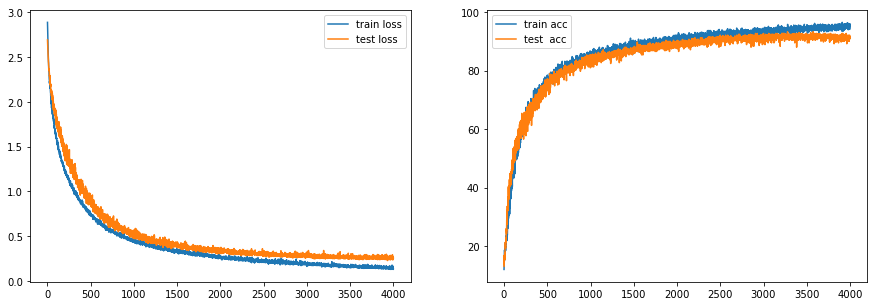

In [12]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [13]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

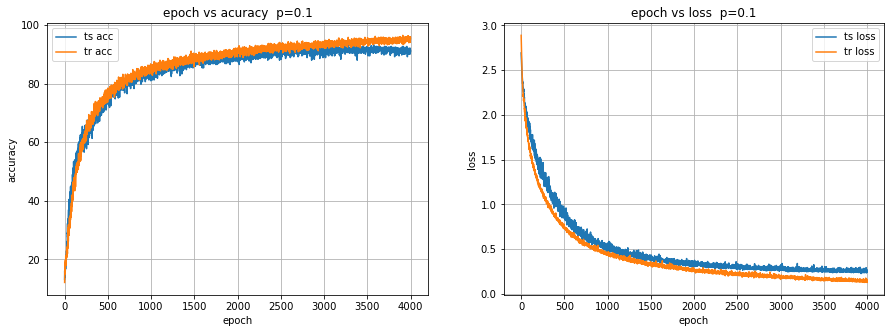

In [14]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    